# Sieć służąca do klasyfikacji pastylek leków - wprowadzenie oraz przygotowanie datasetu
Wykonał Bartłomiej Tarcholik

## Opis projektu
Moim planem było stworzenie sieci neuronowej służącej do klasyfikacji tabletek pod kątem ich kształtu. Moim planem jest stworzenie aplikacji dla osób z chorobami przewlekłymi, która przypominać będzie i kontrolować brane przez taką osobę leki. Ważną częścią tej aplikacji jest dobrze działająca sieć neuronowa, którą postarałem się tutaj stworzyć.

### Dataset
Zestaw danych składa się z 94 obrazków, które zostają automatycznie obrobione w celu stworzenia zestawu obrazków 64x64 piksele, na których uczy się sieć neuronowa. Niestety ilość obrazków jest bardzo ograniczona jako, że musiałem dataset tworzyć sam i z bardzo ograniczoną ilością czasu.

### Historia projektu - co próbowałem?
Rozpocząłem pracę od szukania właściwej technologii do zastosowania w projekcie. W tym celu przeszukałem możliwe istniejące rozwiązania detekcji i zainteresowały mnie przede wszystkim dwa - SSD oraz YOLOv7. Rozpocząłem pracę od SSD, bo wydawało się łatwiejsze, lecz niestety brak możliwych do modyfikacji parametrów zmusił mnie do porzucenia tej sieci na potrzeby projektu. Skierowałem się więc w stronę YOLO, którego Bag of Freebies oraz Bag of Specials dają dużo większe możliwości, lecz YOLO miało problemy same w sobie.

Choćbym nieważne ile próbował, model nie tworzył inferencji na obrazach lub filmach, co koniec końców spowodowało moją decyzję o porzuceniu YOLO.

### Koncept własnej detekcji
Po porażce z wcześniej wspomnianymi metodami detekcji, musiałem zdecydować się na inną formę detekcji, której jednak nie udało mi się finalnie zaimplementować pod kątem wykrywania, lecz została wykorzystana do stworzenia datasetu. Po usłyszeniu ile czasu na analizę jednego obrazka zajmuje podejście Sliding Window, zdecydowałem się na wykorzystanie operacji morfologicznych oraz algorytmu wykrywania krawędzi dostarczanych przez pakiet OpenCV. Napisana została funkcja, która wykrywa obiekty po krawędziach i tworzy z nich kwadratowe bounding boxy, które mogą zostać użyte do wycięcia fragmentu analizowanego obrazka jeden po drugim. Skuteczność czasowa takiego rozwiązania pozwala przyspieszenie analizy jednego obrazka o dowolnej wielkości przynajmniej dwudziestokrotnie w porównaniu ze Sliding Window. Następnie każdy wycinek może zostać przeskalowany i podany do klasyfikacji.
Klasyfikacja daje możliwość sprawdzenia pewności dzięki funkcji wyjściowej, tak więc konkretny wycinek będzie uznawany za brak tabletki w przypadku, w którym pewność nie będzie wystarczająca.

## UWAGA: Błąd został popełniony
Jak piszę pod koniec projektu, popełniłem pewien poważny błąd. Początkowo obrazy przeskalowałem do wielkości 75x75 pikseli, jednak sieć trenuję na 64x64 pikselach. Ten błąd jest prawdopodobnie dosyć znaczący. Dla potrzeb uruchomienia istniejącego kodu, poprawiłem go tutaj, lecz wszystkie wyniki są dla obrazów 75x75 pikseli używanych przez sieć, która skaluje je do 64x64 pikseli, co niewątpliwie powoduje poważną utratę danych obrazów.

## Algorytm Bounding Boxów
Funkcja GetBoundingBoxes jest funkcją gotową do zaimplementowania w dowolnym miejscu, zostanie wykorzystana na pewno w dalszym rozwoju projektu. Wykonuje ona następujące kroki:
1. Pobranie obrazu i przeskalowanie go do mniejszego rozmiaru, żeby algorytm łatwiej wykrywał krawędzie
2. Nałożenie rozmycia Gaussowskiego
3. Zastosowanie algorytmu Canny'ego w celu znalezienia krawędzi na obrazie
4. Dylatacja w celu pogrubienia krawędzi i połączenia dziur w nich
5. Znalezienie konturów
6. Wyliczenie Bounding Boxów dla każdego konturu
7. Usunięcie nadmiarowych Bounding Boxów

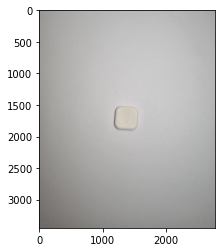

Edges:


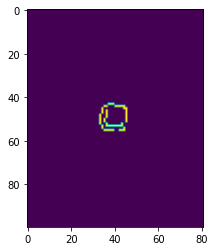

Dilatation:


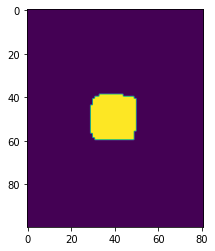

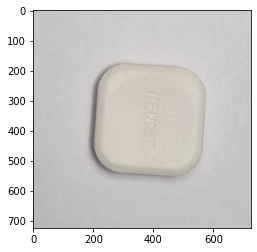

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

def Save(directory, fileName, img):
    if not os.path.exists(directory):
        os.makedirs(directory)
    cv2.imwrite(directory + "/" + fileName, img)

def GetBoundingBoxes(image, sizeToScale, t1, t2, testMode=False):
    x, y, z = image.shape
    newX = 0
    newY = 0
    if x > y:
        newX = sizeToScale
        scale = newX / x
        newY = round(y * scale)
    else:
        newY = sizeToScale
        scale = newY / y
        newX = round(x * scale)
    res = cv2.resize(image, (newY, newX), interpolation = cv2.INTER_AREA)
    img_blur = cv2.GaussianBlur(res, (3,3), 0, 0)
    edges = cv2.Canny(img_blur, threshold1=t1, threshold2=t2)
    if testMode:
        print("Edges:")
        plt.imshow(edges)
        plt.show()
    im_X, im_Y = edges.shape
    kernel = np.ones((5,5),np.uint8)
    dilation = cv2.dilate(edges,kernel,iterations = 2)
    if testMode:
        print("Dilatation:")
        plt.imshow(dilation)
        plt.show()
    ret, thresh = cv2.threshold(dilation, 127, 255, 0)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE,
                                cv2.CHAIN_APPROX_SIMPLE)
    bboxes = []
    for i in range(len(contours)):
        cnt = contours[i]
        x, y, w, h = cv2.boundingRect(cnt)
        if w / im_X > 0.1 and h / im_Y:
            bbox = [[round(x / scale), round(y / scale)], [round((x + w)  / scale), round((y + h)  / scale)]]
            bboxes.append(bbox)
    toMerge = []
    unchanged = False
    while unchanged == False:
        unchanged = True
        for i in range(len(bboxes)):
            if unchanged:
                bbox = bboxes[i]
                start = bbox[0]
                end = bbox[1]
                add = True
                for j in range(len(bboxes)):
                    if i != j and unchanged:
                        other = bboxes[j]
                        st = other[0]
                        en = other[1]
                        dx = min(end[0], en[0]) - max(start[0], st[0])
                        dy = min(end[1], en[1]) - max(start[1], st[1])
                        if (dx>=0) and (dy>=0):
                            inter_area = dx * dy
                            smaller = min(
                            (end[0] - start[0]) * (end[1] - start[1]),
                            (en[0] - st[0]) * (en[1] - st[1])
                            )
                            if inter_area > (0.5 * smaller):
                                bboxes[i][0] = [min(start[0], st[0]), min(start[1], st[1])]
                                bboxes[i][1] = [max(end[0], en[0]), max(end[1], en[1])]
                                bboxes.pop(j)
                                unchanged = False
    for bbox in bboxes:
        xdif = bbox[1][0] - bbox[0][0]
        ydif = bbox[1][1] - bbox[0][1]
        val = round(abs(xdif - ydif) / 2)
        if xdif > ydif:
            y_start = bbox[0][1] - val
            y_end = bbox[1][1] + val
            if y_start < 0:
                offset = abs(y_start)
                y_start = 0
                y_end = y_end + offset
            elif y_end > image.shape[1]:
                offset = y_end - image.shape[1]
                y_end = image.shape[1]
                y_start = y_start - offset
            bbox[0][1] = y_start
            bbox[1][1] = y_end
        else:
            x_start = bbox[0][0] - val
            x_end = bbox[1][0] + val
            if x_start < 0:
                offset = abs(x_start)
                x_start = 0
                x_end = x_end + offset
            elif x_end > image.shape[0]:
                offset = x_end - image.shape[0]
                x_end = image.shape[0]
                x_start = x_start - offset
            bbox[0][0] = x_start
            bbox[1][0] = x_end
    return bboxes

img = cv2.imread("C:/ml/data/pills/original/0028_square_white.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

bx = GetBoundingBoxes(img, 100, 10, 100, True)[0]
plt.imshow(img[bx[0][1]:bx[1][1], bx[0][0]:bx[1][0]])
plt.show()

## Edycja datasetu
Przy użyciu powyższej funkcji każde zdjęcie jest obcinane i przerabiane na nowe. Początkowo były one w 2 różnych miejscach z różnymi konwencjami nazewniczymi, stąd konieczność podzielenia ich na dwie pętle.
Z każdego zdjęcia wycinana jest tabletka, wycinek jest zapisywany jako obraz 64x64 piksele.

In [2]:
dataset_dir = 'C:/ml/data/pills/original'
uploaded_dir = 'C:/ml/data/pills/uploaded'
base_dir = 'C:/ml/data/pills/preprocessed'
full_dir = 'C:/ml/data/pills/preprocessed/full'
final_dir = 'C:/ml/data/pills/final'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

if not os.path.exists(full_dir):
    os.mkdir(full_dir)
    
og_names = [f for f in os.listdir(dataset_dir) if f.endswith('.jpg')]

changes = 0
for fname in og_names:
    nameData = fname.split("_")
    nameData[-1] = nameData[-1][0:-4]
    image = cv2.imread(dataset_dir + "/" + fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    bboxes = GetBoundingBoxes(image, 100, 50, 200)
    if len(bboxes) == 0:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            bboxes = GetBoundingBoxes(image, 100, 10, 100)
            if len(bboxes) != 1:
                print(fname, len(bboxes))
                plt.imshow(image)
                plt.show()
            else:
                bx = bboxes[0]
                img = image[bx[0][1]:bx[1][1], bx[0][0]:bx[1][0]]
                res = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
                Save(final_dir + "/" + nameData[1], str(changes) + ".jpg", res)
                changes += 1
    else:
        bx = bboxes[0]
        img = image[bx[0][1]:bx[1][1], bx[0][0]:bx[1][0]]
        res = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
        Save(final_dir + "/" + nameData[1], str(changes) + ".jpg", res)
        changes += 1

up_dirs = [f for f in os.listdir(uploaded_dir)]

for dir in up_dirs:
    fnames = [f for f in os.listdir(uploaded_dir + "/" + dir)]
    for fname in fnames:
        image = cv2.imread(uploaded_dir + "/" + dir + "/" + fname)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        bboxes = GetBoundingBoxes(image, 100, 50, 200)
        if len(bboxes) == 0:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            bboxes = GetBoundingBoxes(image, 100, 10, 100)
            if len(bboxes) != 1:
                print(dir + "/" + fname, len(bboxes))
                plt.imshow(image)
                plt.show()
            else:
                bx = bboxes[0]
                img = image[bx[0][1]:bx[1][1], bx[0][0]:bx[1][0]]
                res = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
                Save(final_dir + "/" + dir, str(changes) + ".jpg", res)
                changes += 1
        else:
            bx = bboxes[0]
            img = image[bx[0][1]:bx[1][1], bx[0][0]:bx[1][0]]
            res = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
            Save(final_dir + "/" + dir, str(changes) + ".jpg", res)
            changes += 1

print("Dataset has been updated, total changes made:", changes)


Dataset has been updated, total changes made: 94


## Nadrabianie małej ilości zdjęć
W celu nadrobienia małej ilości zdjęć, używam ImageDataGeneratora by stworzyć dużą ich ilość w celach treningowych. Każde zdjęcie jest zniekształcane i zapisywane wiele razy. Dzięki temu każdy kształt posiada przynajmniej 1000 różnych zdjęć do treningu oraz osobno modyfikowane zdjęcia do walidacji. Niestety oznacza to jednak, że jest spore prawdopodobieństwo fałszywej klasyfikacji po podaniu zdjęcia np. kwadratowej tabletki, gdyż niektóre kształty operowały na ekstremalnie małej ilości zdjęć początkowych.

In [3]:
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
img_rows = 64
img_cols = 64

datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=50,
    brightness_range=[0.4, 1.6],
    horizontal_flip=True,
    fill_mode='nearest')

train_dir = 'C:/ml/data/pills/deploy/train'
val_dir = 'C:/ml/data/pills/deploy/val'
dirs = [f for f in os.listdir(final_dir)]
v = 0
for directory in dirs:
    cur_dir = final_dir + "/" + directory
    print(cur_dir)
    images = [f for f in os.listdir(cur_dir) if f.endswith('.jpg')]
    toClone = round(1000 / len(images)) + 1
    for img_path in images:
        im = cv2.imread(cur_dir + "/" + img_path)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        Save(train_dir + "/" + directory, str(changes) + ".jpg", im)
        changes += 1
        img = image.load_img(cur_dir + "/" + img_path, target_size=(img_rows, img_cols))
        x = image.img_to_array(img)
        x = x.reshape((1,) + x.shape)
        i = 0
        for batch in datagen.flow(x, batch_size=1):
            new_image = np.array(image.array_to_img(batch[0]))
            Save(train_dir + "/" + directory, str(changes) + ".jpg", new_image)
            i += 1
            changes += 1
            if i % toClone == 0:
                break
        i = 0
        for batch in datagen.flow(x, batch_size=1):
            new_image = np.array(image.array_to_img(batch[0]))
            Save(val_dir + "/" + directory, str(v) + ".jpg", new_image)
            i += 1
            v += 1
            if i % toClone == 0:
                break

C:/ml/data/pills/final/capsule
C:/ml/data/pills/final/flat-capsule
C:/ml/data/pills/final/oval
C:/ml/data/pills/final/oval-capsule
C:/ml/data/pills/final/round
C:/ml/data/pills/final/square
